# LSTM for generating flavour text from MtG cards

- based on the tutorial at https://machinetalk.org/2019/02/08/text-generation-with-pytorch/

In this notebook we will implement an LSTM to generate flavour text from Magic the Gathering cards.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

import numpy as np
import matplotlib.pyplot as plt

In [34]:
corpus_path = os.path.join(os.getcwd(), 'FlavorText', 'flavortext_corpus.txt')

flags = Namespace(
    train_file=corpus_path,
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64,
    gradients_norm=5,
    initial_words=['I', 'am'],
    predict_top_k=5,
    checkpoint_path='checkpoint',
    num_epoch=1000
)

## Data Preprocessing

We need to tokenize our data (i.e. express words as numbers).

In [35]:
def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r') as f:
        text = f.read()
    text = text.split()

    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text


def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

## Set up the LSTM

In [36]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
        
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
   

    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),
                torch.zeros(1, batch_size, self.lstm_size))
    

In [37]:
def get_loss_and_train_op(net, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    return criterion, optimizer

In [38]:
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    
    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])

    words.append(int_to_vocab[choice])
    
    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))

## Train the LSTM

In [39]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
        flags.train_file, flags.batch_size, flags.seq_size)

    net = RNNModule(n_vocab, flags.seq_size,
                    flags.embedding_size, flags.lstm_size)
    net = net.to(device)

    criterion, optimizer = get_loss_and_train_op(net, 0.01)

    iteration = 0
    loss_history = []
    
    if not os.path.exists(os.path.join(os.getcwd(), 'checkpoint_pt')):
        os.mkdir(os.path.join(os.getcwd(), 'checkpoint_pt'))
    
    for e in range(flags.num_epoch):
        batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
        state_h, state_c = net.zero_state(flags.batch_size)
        
        # Transfer data to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        for x, y in batches:
            iteration += 1
            
            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss_value = loss.item()
            loss_history.append(loss_value)

            # Perform back-propagation
            loss.backward()
            
            _ = torch.nn.utils.clip_grad_norm_(net.parameters(), flags.gradients_norm)

            # Update the network's parameters
            optimizer.step()
            
            
            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, flags.num_epoch),
                      'Iteration: {}'.format(iteration),
                      'Loss: {}'.format(loss_value))

            if iteration % 1000 == 0:
                predict(device, net, flags.initial_words, n_vocab,
                        vocab_to_int, int_to_vocab, top_k=5)
                torch.save(net.state_dict(),
                           'checkpoint_pt/model-{}.pth'.format(iteration))
                
    # Plot training
    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.plot(loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

Vocabulary size 36878
Epoch: 0/5 Iteration: 100 Loss: 7.5920586585998535
Epoch: 0/5 Iteration: 200 Loss: 8.019594192504883
Epoch: 0/5 Iteration: 300 Loss: 7.235413074493408
Epoch: 0/5 Iteration: 400 Loss: 7.503942489624023
Epoch: 1/5 Iteration: 500 Loss: 6.569126605987549
Epoch: 1/5 Iteration: 600 Loss: 6.457633018493652
Epoch: 1/5 Iteration: 700 Loss: 6.337305545806885
Epoch: 1/5 Iteration: 800 Loss: 5.926801681518555
Epoch: 1/5 Iteration: 900 Loss: 6.407848358154297
Epoch: 2/5 Iteration: 1000 Loss: 5.880000591278076
I am the same world. ---------- "I do it is always that it was to find a single few and a matter of his own own side. edificer They are not for its eternal perfection. But he was the battlefield ---------- It was known to find its victims in the most world of his mind ---------- "I have been the world of their victims have seen his one who would find the world and all a thousand Chieftain ---------- The Eldrazi can find their mind to be the world and all that I can be the

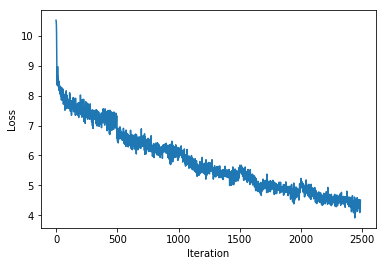

In [40]:
if __name__ == '__main__':
    main()